# Practical 4: DynamicProgramming

In [1]:
import numpy as np
import rldurham as rld

## Frozen Lake Environment

In [2]:
env = rld.make(
    'FrozenLake-v1',         # small version
    # 'FrozenLake8x8-v1',    # larger version
    # desc=["GFFS", "FHFH", "FFFH", "HFFG"],  # custom map
    render_mode="rgb_array", # for rendering as image/video
    is_slippery=False,       # warning: slippery=True results in complex dynamics
)
rld.env_info(env, print_out=True)
rld.seed_everything(42, env)
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

Seed set to 42


actions are discrete with 4 dimensions/#actions (action space: Discrete(4))
observations are discrete with 16 dimensions/#observations (observation space: Discrete(16))
maximum timesteps is: 100


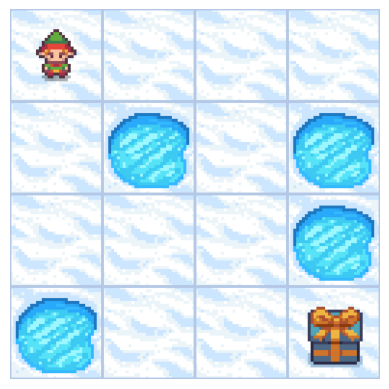

In [3]:
# render the environment (requires render_mode="rgb_array")
rld.render(env)

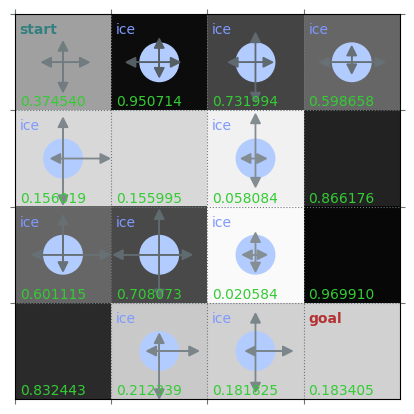

In [4]:
# helper function that can also plot policies and value functions
rld.plot_frozenlake(env=env,
                    v=np.random.uniform(0, 1, 16),
                    policy=np.random.uniform(0, 1, (16, 4)), 
                    draw_vals=True)

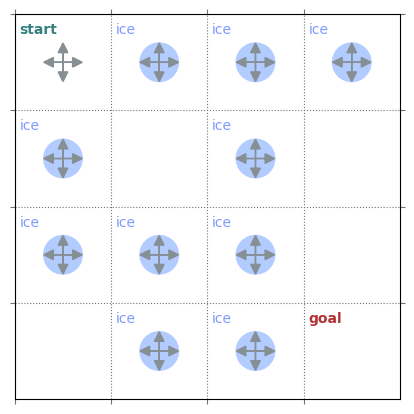

In [5]:
def uniform_policy(env):
    return np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
rld.plot_frozenlake(env=env, policy=uniform_policy(env))

## Policy Evaluation

In [6]:
def policy_eval_step(env, policy, gamma, v_init=None):
    if v_init is None:
        v_init = np.zeros(env.observation_space.n)
    v = np.zeros(env.observation_space.n)
    for s_from in range(env.observation_space.n):
        for a in range(env.action_space.n):
            pi = policy[s_from, a]
            for p, s_to, r, done in env.P[s_from][a]:
                v[s_from] += pi * p * (r + gamma * v_init[s_to])
    return v

In [7]:
v = np.zeros(env.observation_space.n)

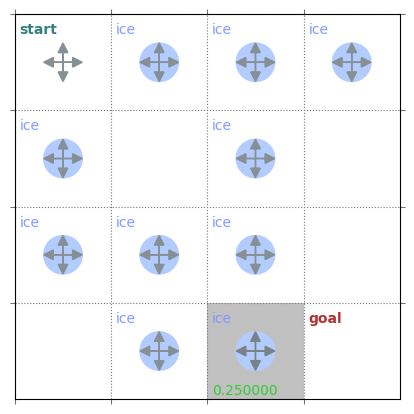

In [8]:
v = policy_eval_step(env, uniform_policy(env), 1, v)
rld.plot_frozenlake(env, v, uniform_policy(env), draw_vals=True)

In [9]:
def policy_eval_step_inplace(env, policy, gamma, v_init=None):
    if v_init is None:
        v_init = np.zeros(env.observation_space.n)
    v = v_init.copy() # opearate on copy in-place
    for s_from in reversed(range(env.observation_space.n)):  # reverse order of states
        v_s_from = 0  # compute value for this state
        for a in range(env.action_space.n):
            pi = policy[s_from, a]
            for p, s_to, r, done in env.P[s_from][a]:
                v_s_from += pi * p * (r + gamma * v[s_to])  # use the values we also update
        v[s_from] = v_s_from  # update
    return v

In [10]:
v = np.zeros(env.observation_space.n)

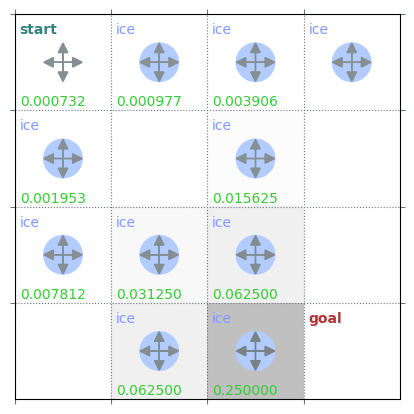

In [11]:
v = policy_eval_step_inplace(env, uniform_policy(env), 1, v)
rld.plot_frozenlake(env, v, uniform_policy(env), draw_vals=True)

In [12]:
def policy_evaluation(env, policy, gamma, v_init=None, print_iter=False, atol=1e-8, max_iter=10**10):
    if v_init is None:
        v_init = np.zeros(env.observation_space.n)
    v = v_init
    for i in range(1, max_iter + 1):
        new_v = policy_eval_step(env, policy, gamma, v)
        # new_v = policy_eval_step_inplace(env, policy, gamma, v)
        if np.allclose(v, new_v, atol=atol):
            break
        v = new_v
    if print_iter:
        print(f"{i} iterations")
    return v

60 iterations


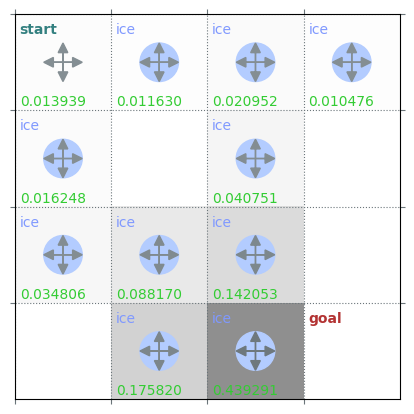

In [13]:
v = policy_evaluation(env, uniform_policy(env), 1, print_iter=True)
rld.plot_frozenlake(env, v, uniform_policy(env), draw_vals=True)

## Policy Improvement

In [14]:
def q_from_v(env, v, s, gamma):
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for p, s_to, r, done in env.P[s][a]:
            q[a] += p * (r + gamma * v[s_to])
    return q

In [15]:
def policy_improvement(env, v, gamma, deterministic=False):
    policy = np.zeros([env.observation_space.n, env.action_space.n]) / env.action_space.n
    for s in range(env.observation_space.n):
        q = q_from_v(env, v, s, gamma)
        if deterministic:
            # deterministic policy
            policy[s][np.argmax(q)] = 1
        else:
            # stochastic policy with equal probability on maximizing actions
            best_a = np.argwhere(q==np.max(q)).flatten()
            policy[s, best_a] = 1 / len(best_a)
    return policy

In [16]:
env = rld.make('FrozenLake8x8-v1', is_slippery=False)
rld.seed_everything(42, env)
gamma = 1
policy = uniform_policy(env)

Seed set to 42


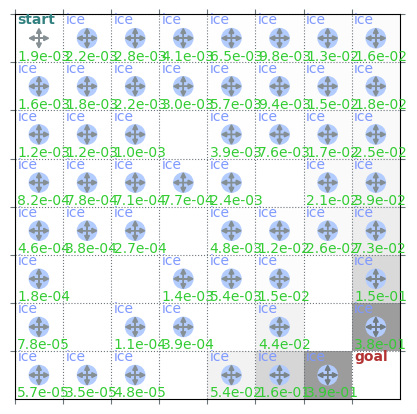

In [17]:
v = policy_evaluation(env, policy, gamma=gamma)
rld.plot_frozenlake(env, v=v, policy=policy, draw_vals=True)

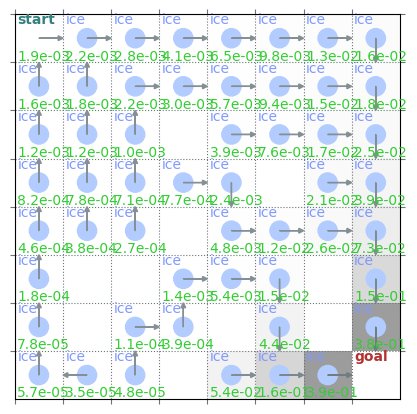

In [18]:
policy = policy_improvement(env, v, gamma=gamma)
rld.plot_frozenlake(env, v=v, policy=policy, draw_vals=True)

## Policy Iteration

In [19]:
env = rld.make('FrozenLake8x8-v1', is_slippery=False)
rld.seed_everything(42, env)
policy = uniform_policy(env)
gamma = 1

Seed set to 42


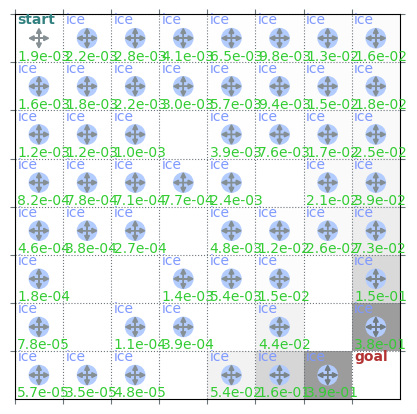

[1.90305548e-03 2.16927106e-03 2.81470378e-03 4.12015600e-03
 6.54735001e-03 9.80286246e-03 1.34473983e-02 1.59696876e-02
 1.63695191e-03 1.79015872e-03 2.15477757e-03 2.99849785e-03
 5.71911640e-03 9.41393023e-03 1.45697438e-02 1.84920808e-02
 1.21774169e-03 1.19972568e-03 1.01582543e-03 0.00000000e+00
 3.91675258e-03 7.56407249e-03 1.69256504e-02 2.49369022e-02
 8.16627609e-04 7.75246174e-04 7.08844457e-04 7.73171495e-04
 2.38385304e-03 0.00000000e+00 2.06319427e-02 3.93930442e-02
 4.56952350e-04 3.75834825e-04 2.71166118e-04 0.00000000e+00
 4.84550082e-03 1.15941715e-02 2.62091075e-02 7.26103323e-02
 1.78428991e-04 0.00000000e+00 0.00000000e+00 1.44835445e-03
 5.40398429e-03 1.53220842e-02 0.00000000e+00 1.52228870e-01
 7.83491898e-05 0.00000000e+00 1.09382492e-04 3.89434175e-04
 0.00000000e+00 4.42901833e-02 0.00000000e+00 3.84076289e-01
 5.66254312e-05 3.49065027e-05 4.80960655e-05 0.00000000e+00
 5.39462166e-02 1.61838650e-01 3.87279550e-01 0.00000000e+00]


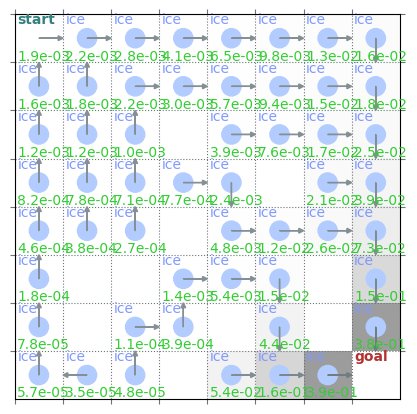

In [20]:
v = policy_evaluation(env, policy, gamma=gamma)
rld.plot_frozenlake(env, v=v, policy=policy, draw_vals=True)
print(v)
policy = policy_improvement(env, v, gamma=gamma)
rld.plot_frozenlake(env, v=v, policy=policy, draw_vals=True)